In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from wgan import FE, Discriminator, Classifier, Wasserstein_Loss, Grad_Loss
from tqdm import tqdm
import os
from scipy import io
import numpy as np
from train_val_model import printsave, train_val, make_dataloader

In [2]:
import os
os.getcwd()

'/home/hun/바탕화면/AAI/DRDA_Wasserstein_Loss'

In [3]:
log = open("log.txt", "w")
print("DRDA_Wasserstein_Loss\n", file=log)
log.close()

In [7]:
# path
path = r'../data_preprocessed_matlab/'  # 경로는 저장 파일 경로
file_list = os.listdir(path)

printsave("data path check")
for i in file_list:    # 확인
    printsave(i, end=' ')


for i in tqdm(file_list, desc="read data"): 
    mat_file = io.loadmat(path+i)
    data = mat_file['data']
    labels = np.array(mat_file['labels'])
    val = labels.T[0].round().astype(np.int8)
    aro = labels.T[1].round().astype(np.int8)
    
    if(i=="s05.mat"): 
        Data = data
        VAL = val
        ARO = aro
        continue
        
    Data = np.concatenate((Data ,data),axis=0)   # 밑으로 쌓아서 하나로 만듬
    VAL = np.concatenate((VAL ,val),axis=0)
    ARO = np.concatenate((ARO ,aro),axis=0)

data path check
s05.mat s08.mat s17.mat s07.mat s06.mat s27.mat s22.mat s10.mat s25.mat s20.mat s16.mat s15.mat s21.mat s03.mat s02.mat s31.mat s11.mat s12.mat s32.mat s13.mat s29.mat s09.mat s28.mat s01.mat s30.mat s14.mat s19.mat s26.mat s04.mat s18.mat s24.mat s23.mat 

read data: 100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


In [8]:
# eeg preprocessing

eeg_data = []
peripheral_data = []

for i in tqdm(range(len(Data)), desc="preprocess channel"):
    for j in range (40): 
        if(j < 32): # get channels 1 to 32
            eeg_data.append(Data[i][j])
        else:
            peripheral_data.append(Data[i][j])

# set data type, shape
eeg_data = np.reshape(eeg_data, (len(Data),1,32, 8064))
eeg_data = eeg_data.astype('float32')
eeg_data32 = torch.from_numpy(eeg_data)
VAL = (torch.from_numpy(VAL)).type(torch.long)
ARO = (torch.from_numpy(ARO)).type(torch.long)

preprocess channel: 100%|██████████| 1280/1280 [00:00<00:00, 128042.86it/s]


In [9]:
source_VAL, target_VAL, val_VAL = make_dataloader(eeg_data32, VAL)
source_ARO, target_ARO, val_ARO = make_dataloader(eeg_data32, ARO)

data split
make data loader
data split
make data loader


In [ ]:
fe_VAL, dis_VAL, cls_VAL = train_val(source_VAL, target_VAL, val_VAL, 'VALENCE', 1000, 10, 10, 10, 100)



VALENCE label train and valiation
device:  cuda:0

1 : epoch

gloss : -71.80778503417969
wd_loss : 0.7517369985580444
cls_loss : 2.1772470474243164
acc_t : 0.16796875
acc_s : 0.28515625
val_loss : 2.1974103927612303
acc_val : 0.165625
best_val_loss : 2.1974103927612303, epoch : 1

2 : epoch

gloss : -32.0081672668457
wd_loss : 1.9999895095825195
cls_loss : 2.163511037826538
acc_t : 0.189453125
acc_s : 0.34765625
val_loss : 2.1976989269256593
acc_val : 0.153125
best_val_loss : 2.1974103927612303, epoch : 1

3 : epoch

gloss : 5.712507247924805
wd_loss : 3.267773389816284
cls_loss : 2.1536595821380615
acc_t : 0.185546875
acc_s : 0.365234375
val_loss : 2.1974744319915773
acc_val : 0.153125
best_val_loss : 2.1974103927612303, epoch : 1

4 : epoch

gloss : 38.308143615722656
wd_loss : 5.230515956878662
cls_loss : 2.1460089683532715
acc_t : 0.171875
acc_s : 0.416015625
val_loss : 2.1976836681365968
acc_val : 0.153125
best_val_loss : 2.1974103927612303, epoch : 1

5 : epoch

gloss : 35.2986



AROUSAL label train and valiation
device:  cuda:0

1 : epoch

gloss : -44.25697326660156
wd_loss : 1.6806535720825195
cls_loss : 2.1717569828033447
acc_t : 0.1875
acc_s : 0.35546875
val_loss : 2.1943238258361815
acc_val : 0.153125
best_val_loss : 2.1943238258361815, epoch : 1

2 : epoch

gloss : 10.759665489196777
wd_loss : 3.664621114730835
cls_loss : 2.1614749431610107
acc_t : 0.173828125
acc_s : 0.4140625
val_loss : 2.194812536239624
acc_val : 0.1625
best_val_loss : 2.1943238258361815, epoch : 1

3 : epoch

gloss : 43.905330657958984
wd_loss : 6.096080303192139
cls_loss : 2.1535847187042236
acc_t : 0.20703125
acc_s : 0.435546875
val_loss : 2.194874906539917
acc_val : 0.16875
best_val_loss : 2.1943238258361815, epoch : 1

4 : epoch

gloss : 92.28178405761719
wd_loss : 10.38113784790039
cls_loss : 2.148451089859009
acc_t : 0.18359375
acc_s : 0.439453125
val_loss : 2.1950387954711914
acc_val : 0.165625
best_val_loss : 2.1943238258361815, epoch : 1

5 : epoch

gloss : -548.62969970703

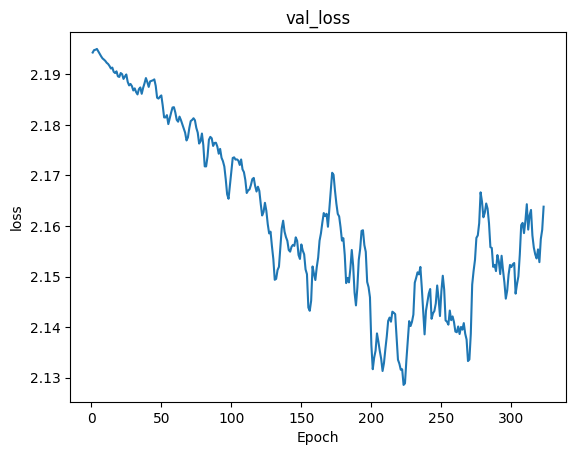

In [10]:
fe_ARO, dis_ARO, cls_ARO = train_val(source_ARO, target_ARO, val_ARO, 'AROUSAL', 1000, 10, 10, 10, 100)